In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

### Load and filter data

In [2]:
from nanomesh.volume import Volume
vol = Volume.load('sample_data.npy')

plane = vol.select_plane(x=161)
plane_gauss = plane.gaussian(sigma=5)
thresh = plane_gauss.threshold('li')
segmented = plane_gauss.digitize(bins=[thresh])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Generate mesh

In [3]:
from nanomesh.mesh2d import Mesher2D

mesher = Mesher2D(plane_gauss)
mesher.generate_contours(max_contour_dist = 3, contour_precision=1, level=thresh)
    
mesh = mesher.triangulate(opts='q30a100')

q30a100


### Save data + contours to gmsh format

In [4]:
import meshio

LINE = 1
TRIANGLE = 2

field_data = {
        'Pore': [0, TRIANGLE],
        'Silicon': [1, TRIANGLE],
        'External boundary': [1, LINE],
        'Internal boundary': [2, LINE],
    }

msh = meshio.Mesh(
    points=mesh.points,
    cells={
        'line': mesh.edges,
        'triangle': mesh.cells},
    field_data = field_data,
    cell_data = {'gmsh:physical': [
                mesh.edge_markers.squeeze(),
                mesh.labels,
    ]}
)

msh.write('out.msh', file_format='gmsh22', binary=False)

msh2 requires 3D points, but 2D points given. Appending 0 third component.
Appending zeros to replace the missing geometrical tag data.


### Load data using meshio

In [6]:
msh = meshio.read('out.msh')

dim1_fields = {}
dim2_fields = {}
for name, (tag, dimension) in msh.field_data.items():
    if dimension == 1:
        dim1_fields[tag] = name
    elif dimension == 2:
        dim2_fields[tag] = name
    else:
        print(dimension, tag, name, '??')

print(dim1_fields)
print(dim2_fields)

{1: 'External boundary', 2: 'Internal boundary'}
{0: 'Pore', 1: 'Silicon'}


### Plot data using matplotlib

<IPython.core.display.Javascript object>


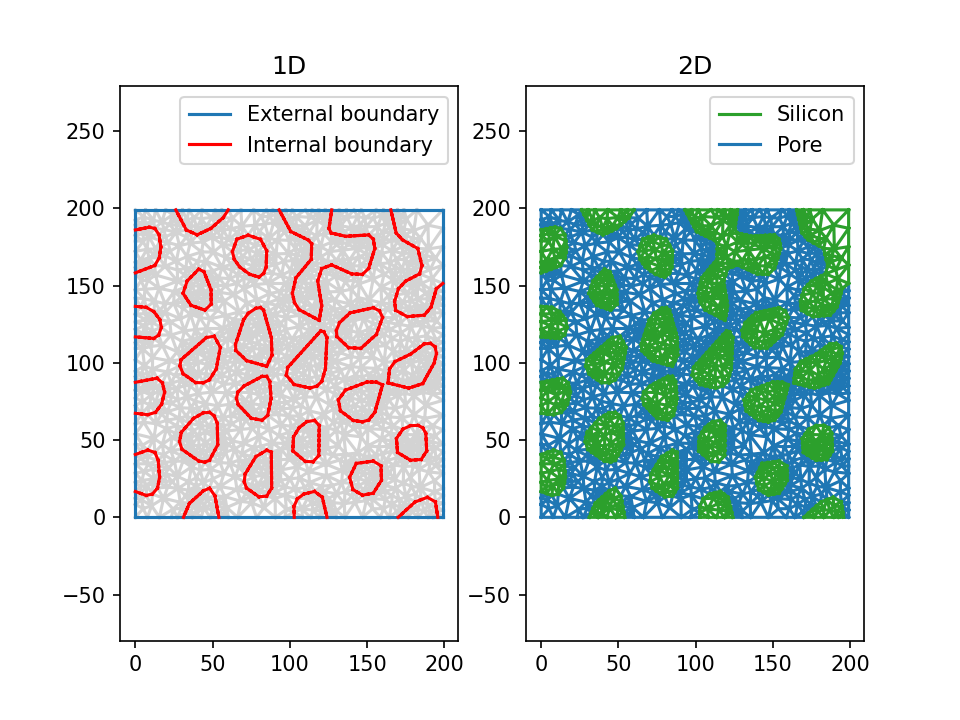

(1754, 2) (5127, 2) (5127,)
{1: 'External boundary', 2: 'Internal boundary'}
1D 0 None lightgray
1D 1 External boundary tab:blue
1D 2 Internal boundary red
1D 3 None red
1D 4 None red
1D 5 None red
1D 6 None red
1D 7 None red
1D 8 None red
1D 9 None red
1D 10 None red
1D 11 None red
1D 12 None red
1D 13 None red
1D 14 None red
1D 15 None red
1D 16 None red
1D 17 None red
1D 18 None red
1D 19 None red
1D 20 None red
1D 21 None red
1D 22 None red
1D 23 None red
1D 24 None red
1D 25 None red
(1754, 2) (3374, 3) (3374,)
{0: 'Pore', 1: 'Silicon'}
2D 0 Pore lightgray
2D 1 Silicon tab:blue


In [10]:
import matplotlib.pyplot as plt
from nanomesh.mesh2d.helpers import _legend_with_triplot_fix
from nanomesh.mpl.lineplot import lineplot

colors = {
    1: 'tab:blue',
    2: 'tab:orange',
}
for x in range(2, 100):
    colors[x] = 'red'


# cell_group = 'gmsh:geometrical'
cell_group = 'gmsh:physical'

fig, axes = plt.subplots(ncols=2)

for ax, dim_name in zip(axes, ('1D', '2D')):
    if dim_name == '1D':
        dim = 0
        fields = dim1_fields  # dim1 = 1D elements, lines
    else:
        dim = 1
        fields = dim2_fields  # dim2 = 2D elements, triangles

    points = msh.points[:,:2]
    cells = msh.cells[dim].data
    labels = msh.cell_data[cell_group][dim]

    print(points.shape, cells.shape, labels.shape)
    print(fields)

    for label in np.unique(labels):
        idx = labels == label
        x, y = points.T
        name = fields.get(label, None)
        color = colors.get(label, 'lightgray')
    
        print(dim_name, label, name, color)
        
        if dim_name == "1D":
            line_plot(ax, x=x, y=y, lines=cells, mask=~idx, label=name)
        else:
            ax.triplot(x, y, triangles=cells, mask=~idx, label=name)

    ax.legend()

    if dim_name == "2D":
        _legend_with_triplot_fix(ax)
    
    ax.axis('equal')
    ax.set_title(dim_name)

In [11]:
ax.triplot?